# affiliations

INDEX

In [2]:
# Libraries
import pandas as pd

# Abstract Syntax Trees
import ast

# Functions
import sys
sys.path.append('../src')
from support_clean import *

# Coordenates
from geopy.geocoders import GoogleV3
from geopy.exc import GeocoderTimedOut

### Import affiliations_df

In [3]:
affiliations = pd.read_csv('../data/affiliations_df.csv')
affiliations.head(2)

,Unnamed: 0,pub_id,authors,auth_aff_list,first_auth_aff,last_auth_aff
0,0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


## Data Cleansing

In [4]:
df = affiliations.copy()

In [5]:
to_drop = ['Unnamed: 0']
display(df.shape)
df = df.drop(columns=to_drop)
display(df.shape)

(61981, 6)

(61981, 5)

In [6]:
df = df.rename(columns={'ID': 'pub_id'})
df.head(2)

,pub_id,authors,auth_aff_list,first_auth_aff,last_auth_aff
0,38012702,"['Wu, Anbiao', 'Zhang, Jiyan']","['Beijing Institute of Basic Medical Sciences,...","Beijing Institute of Basic Medical Sciences, B...","Beijing Institute of Basic Medical Sciences, B..."
1,38012669,"['Zheng, Shengnan', 'Li, Yiquan', 'Song, Xiaom...","['Department of Pharmacology, School of Basic ...","Department of Pharmacology, School of Basic Me...","Department of Rehabilitation Medicine, The Sec..."


### Create a list of affiliations

In [7]:
# Fill NaN values with empty lists
df['auth_aff_list'] = df['auth_aff_list'].fillna('[]')

In [8]:
# Transform the strings to lists again
df['auth_aff_list'] = df['auth_aff_list'].apply(ast.literal_eval)

In [9]:
# Create a row per affiliation
df_aff = df.explode('auth_aff_list')

In [10]:
df_aff['auth_aff_list']

0        Beijing Institute of Basic Medical Sciences, B...
0        Beijing Institute of Basic Medical Sciences, B...
1        Department of Pharmacology, School of Basic Me...
1        Department of Pharmacology, School of Basic Me...
1        Department of Pharmacology, School of Basic Me...
                               ...                        
61980    Department of Radiology, Liyuan Hospital, Tong...
61980    Department of Radiology, Liyuan Hospital, Tong...
61980    State Key Laboratory of Brain and Cognitive Sc...
61980    Sino-Danish College, University of Chinese Aca...
61980    Center for Excellence in Brain and Science and...
Name: auth_aff_list, Length: 374373, dtype: object

In [11]:
# Create a list of unique affiliations
display(df_aff.shape)
aff_unique = list(set(df_aff['auth_aff_list']))
len(aff_unique)

(374373, 5)

133868

In [12]:
aff_df = pd.DataFrame(aff_unique, columns=['affiliation_names'])

In [16]:
aff_df = aff_df.dropna()

In [17]:
# Create a column aff_id
aff_df['aff_id'] = aff_df.index

C:\Users\ingle\AppData\Local\Temp\ipykernel_13920\2903328238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aff_df['aff_id'] = aff_df.index


In [18]:
aff_df

,affiliation_names,aff_id
0,"The fourth affiliated hospital, Harbin Medical...",0
1,"Department of Biology, University of Padova, P...",1
2,Department of Clinical Sciences and Community ...,2
3,"Department of Biostatistics, Erciyes Universit...",3
4,"Department of Microbiology, Immunology and Tra...",4
...,...,...
133863,Buddhist Practices and Counselling Science Lab...,133863
133864,"Cardiovascular Research Institute, University ...",133864
133865,"School of Education, Victoria University of We...",133865
133866,"CNRS, UMR 7232, BIOM, Observatoire Océanologiq...",133866


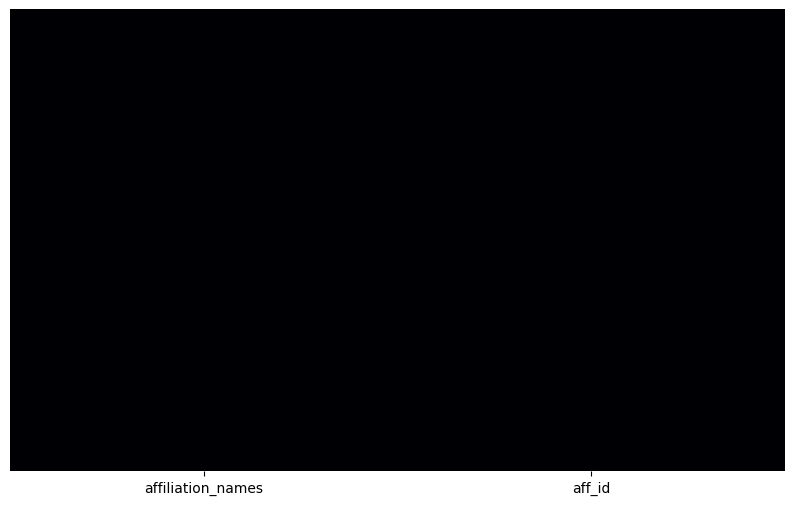

In [19]:
view_nan(aff_df)

## Determine the geographical locations of the affiliations

In [46]:
with open('../google_api_key.txt', 'r') as file:
    google_api_key = file.read().strip()

geolocator = GoogleV3(api_key=google_api_key)

In [47]:
def obtain_long_lat_country(loc):
    '''
    Obtain the longitude, latitude, and country for a given location.

    Parameters:
    - location (str): The name of the location for which coordinates and country are desired.

    Returns:
    - Tuple[float, float, str]: A tuple containing the obtained longitude, latitude, and country.
      If the location cannot be geocoded successfully, (None, None, None) is returned.
    '''
    try:
        location = geolocator.geocode(loc, language='en')  # Set language for consistent results
        if location:
            return location.longitude, location.latitude, location.raw.get('country')
        else:
            return None, None, None
    except GeocoderTimedOut:
        return None, None, None

In [50]:
aff_df['longitude'], aff_df['latitude'], aff_df['country'] = zip(*aff_df['affiliation_names'].apply(obtain_long_lat_country))

C:\Users\ingle\AppData\Local\Temp\ipykernel_13920\1935610478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aff_df['longitude'], aff_df['latitude'], aff_df['country'] = zip(*aff_df['affiliation_names'].apply(obtain_long_lat_country))
C:\Users\ingle\AppData\Local\Temp\ipykernel_13920\1935610478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aff_df['longitude'], aff_df['latitude'], aff_df['country'] = zip(*aff_df['affiliation_names'].apply(obtain_long_lat_country))
C:\Users\ingle\AppData\Local\Temp\

#### Manage NaNs

In [53]:
aff_df.isna().sum()

affiliation_names         0
aff_id                    0
longitude             25111
latitude              25111
country              133194
dtype: int64

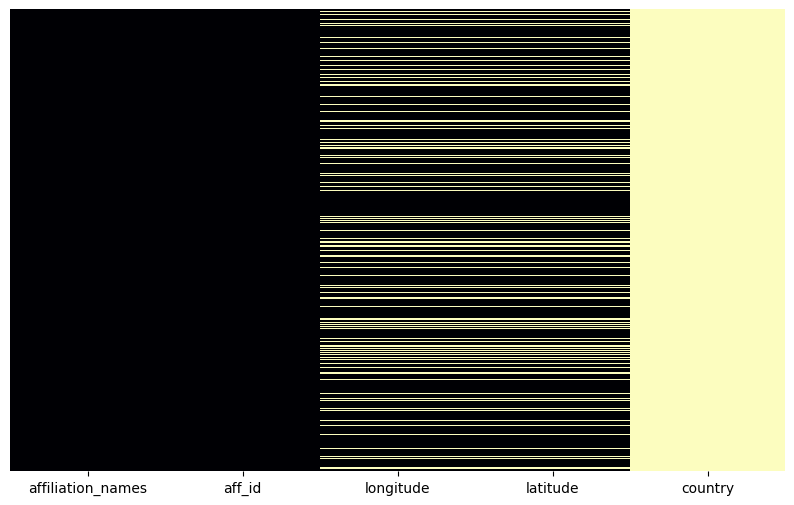

In [55]:
view_nan(aff_df)

In [56]:
to_drop = ['country']
display(aff_df.shape)
aff_df = aff_df.drop(columns=to_drop)
display(aff_df.shape)

(133194, 5)

(133194, 4)

In [57]:
aff_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133194 entries, 0 to 133867
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   affiliation_names  133194 non-null  object 
 1   aff_id             133194 non-null  int64  
 2   longitude          108083 non-null  float64
 3   latitude           108083 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.1+ MB


In [60]:
aff_df['affiliation_names'][aff_df['longitude'].isna()]

4         Department of Microbiology, Immunology and Tra...
5         Department of Neurology, Keimyung University S...
7         Cátedra de Bioestadística, Facultad de Ciencia...
8         Department of Integrated Traditional Chinese a...
11        CAS Key Laboratory of Brain Function and Disea...
                                ...                        
133849    Centro de Neurobiología y Fisiología Integrati...
133851    Unidad de Investigación en Epidemiológica Clín...
133855    Department of Neurology, The General Hospital ...
133856    Laboratório de Bioenergética e Estresse Oxidat...
133857    Programa de Pós-Graduação em Neurociências, Ce...
Name: affiliation_names, Length: 25111, dtype: object

In [61]:
# Fill NaN Values with 0.0
aff_df['longitude'] = aff_df['longitude'].fillna(0.0)
aff_df['latitude'] = aff_df['latitude'].fillna(0.0)

In [67]:
aff_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133194 entries, 0 to 133867
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   affiliation_names  133194 non-null  object 
 1   aff_id             133194 non-null  int64  
 2   longitude          133194 non-null  float64
 3   latitude           133194 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.1+ MB


In [66]:
aff_df.shape

(133194, 4)

In [68]:
aff_df.to_csv('../data/neuropapers_db/affiliations.csv', index=False)

In [70]:
pd.set_option('display.max_colwidth', None)

In [71]:
aff_df['affiliation_names']

0           The fourth affiliated hospital, Harbin Medical University, Harbin, Heilongjiang 
1                                 Department of Biology, University of Padova, Padua, Italy.
2         Department of Clinical Sciences and Community Health, University of Milan, Milan, 
3                          Department of Biostatistics, Erciyes University, Kayseri, Turkey.
4                 Department of Microbiology, Immunology and Transplantation, Laboratory of 
                                                 ...                                        
133863      Buddhist Practices and Counselling Science Lab, Centre of Buddhist Studies, The 
133864       Cardiovascular Research Institute, University of California San Francisco, San 
133865      School of Education, Victoria University of Wellington, Wellington, New Zealand.
133866           CNRS, UMR 7232, BIOM, Observatoire Océanologique, Banyuls-sur-Mer, France; 
133867        Department of Ophthalmology, Flinders Medical Center and